In [21]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from allen_v1dd.client import EMClient

In [8]:
em_client = EMClient()

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


# See table names

In [3]:
em_client.get_tables()

['ariadne_axon_task',
 'functional_coregistration_v1',
 'manual_pilot_functional_coregistration_v1',
 'correspondance_pilot',
 'ariadne_multisoma_proofreading_v1',
 'ariadne_dendrite_proofreading_v2',
 'ariadne_axon_proofreading_v1',
 'synapses_v1dd',
 'multisoma_split_task',
 'ariadne_dendrite_task',
 'ophys_examples',
 'manual_central_types',
 'nucleus_detection_v0']

# Query table example: Plot soma positions

In [4]:
nucleus_df = em_client.query_table("nucleus_detection_v0")
nucleus_df["pt_position_microns"] = em_client.transform_position_to_microns(nucleus_df["pt_position"]) # Add a column mapping position to microns
nucleus_df

In [9]:
nucleus_df.drop_duplicates("pt_root_id", inplace=True) # Drop duplicate pt_root_ids
len(nucleus_df)

155652

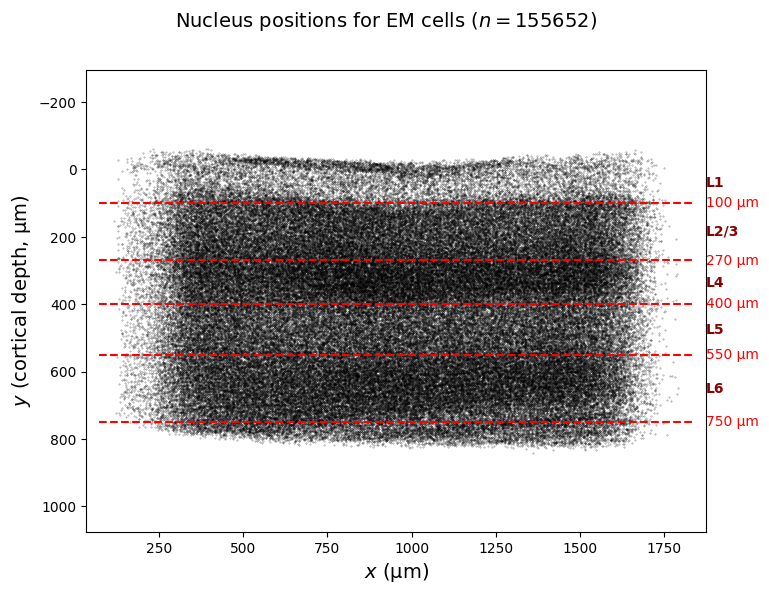

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

x_pos = nucleus_df.pt_position_microns.apply(lambda pos: pos[0])
y_pos = nucleus_df.pt_position_microns.apply(lambda pos: pos[1])
z_pos = nucleus_df.pt_position_microns.apply(lambda pos: pos[2])

# Normalize the y points
# q = 0.005
# y_min, y_max = np.quantile(y, [q, 1-q])
# y = (y - y_min) / (y_max - y_min) * y_max

fig.suptitle(f"Nucleus positions for EM cells ($n = {len(nucleus_df)}$)", fontsize=14)
ax.scatter(x_pos, y_pos, color="black", s=0.1, alpha=0.5)
ax.set_xlabel(f"$x$ (µm)", fontsize=14)
ax.set_ylabel("$y$ (cortical depth, µm)", fontsize=14)

ax.axis("equal")
ax.set_ylim(y_pos.min(), y_pos.max())
ax.invert_yaxis() # Open down

text_trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)

for layer, (depth_min, depth_max) in em_client.layer_boundaries.items():
    ax.axhline(depth_max, xmin=0.02, xmax=0.98, color="red", linestyle="dashed")
    ax.text(1, depth_max, f"{depth_max} µm", ha="left", va="center", color="red", fontsize=10, transform=text_trans)
    text_depth = depth_max - 60 if np.isinf(depth_min) else (depth_min + depth_max) / 2
    ax.text(1, text_depth, f"L{layer}", ha="left", va="center", color="darkred", fontweight="bold", transform=text_trans)

# Count cells with proofreading

In [24]:
axo_proof_df = em_client.get_axon_proofreading_table()
den_proof_df = em_client.get_dendrite_proofreading_table()

In [32]:
print("Axon:")
print(axo_proof_df.cell_type.value_counts())
print("\nDendrite:")
print(den_proof_df.cell_type.value_counts())

Axon:
submitted    799
clean         66
complete       9
Name: cell_type, dtype: int64

Dendrite:
submitted    2420
complete       13
Name: cell_type, dtype: int64
